## PyTorch Custom Dataset
### Let's practice how to learn how to get our own data into pytorch.

In [1]:
import torch
from torch import nn

# PyTorch 1.10.0+ is required for this course
torch.__version__

'2.3.0+cu121'

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### 1. Get dataset from github since it is a subset of Food101 created.

In [3]:
# get data
import requests
import zipfile
from pathlib import Path

# set up path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# if image folder doesn't exist, download and prepare it
if image_path.is_dir():
  print(f"{image_path} directory already exists... skipping download")
else:
  print(f"{image_path} does not exist, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)  # by providing the exist_ok=True argument, it ensures that no error is raised if the directory already exists
                                                 # parents=True - This parameter ensures that any missing intermediate directories in the specified path are also created.
                                                 # For example, if image_path is "parent_dir/new_dir", and "parent_dir" does not exist, setting parents=True
                                                 # will create both "parent_dir" and "new_dir".

# download pizza, steak, and sushi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  # "wb" is passed to open() to open the file in binary write mode, which is necessary when dealing with non-text files e.g. ZIP
  # BE CAREFUL! Using the blob link below may raise an error.
  # request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi.zip")
  # Therefore, URL is declared, which is the raw file rather the blob file
  URL = "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip"
  request = requests.get(URL)
  print("Downloading pizza, steak, sushi data...")
  f.write(request.content)
# unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza, steak, sushi data...")
  zip_ref.extractall(image_path)
  print("Unzipping completed!")

data/pizza_steak_sushi does not exist, creating one...
Unzipping pizza, steak, sushi data...
Unzipping completed!


### 2. Now you have become the one with the data, so let's do some data preparation and data exploration.

In [4]:
import os

def walk_through_dir(dirpath):
  """Walks through dir_path returning its contents."""
  for dirpath, dirnames, filenames in os.walk(dirpath):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

In [5]:
walk_through_dir(image_path)

There are 2 directories and 0 images in data/pizza_steak_sushi
There are 3 directories and 0 images in data/pizza_steak_sushi/test
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza
There are 3 directories and 0 images in data/pizza_steak_sushi/train
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza


In [6]:
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

#### 2.1 Visualizing an Image

In [7]:
image_path

PosixPath('data/pizza_steak_sushi')

In [8]:
# /content/data/pizza_steak_sushi

pizza
Random Image Path: data/pizza_steak_sushi/train/pizza/3281494.jpg
Image Class: pizza
Image Height: 288
Image Width: 512


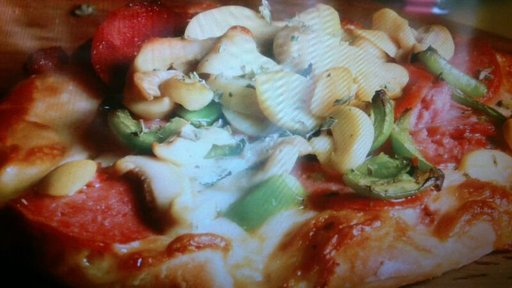

In [9]:
import random
from PIL import Image

# set seed
# random.seed(42)

# 1. get all image paths
# This part of the code uses the glob method of the image_path object to generate an iterator
# that yields all file paths matching a specific pattern. In this case, the pattern is "*/*/*.jpg",
# which matches all files with the .jpg extension located two levels deep within the directory
# structure specified by image_path.
image_path_list = list(image_path.glob("*/*/*.jpg"))
# print(image_path_list)

# 2. pick a random image
random_image_path = random.choice(image_path_list)
# print(random_image_path)

# 3. get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem  # parent returns the address, stem return the last directory e.g. pizza in our example
print(image_class)

# 4. open image
# The Image module from the PIL or Pillow library provides the open() function,
# which is used to open an image file.
img = Image.open(random_image_path)

# 5. print metadata
print(f"Random Image Path: {random_image_path}")
print(f"Image Class: {image_class}")
print(f"Image Height: {img.height}")
print(f"Image Width: {img.width}")
img

#### 2.2 Now let's try to visualize and image with matplotlib...

(-0.5, 511.5, 287.5, -0.5)

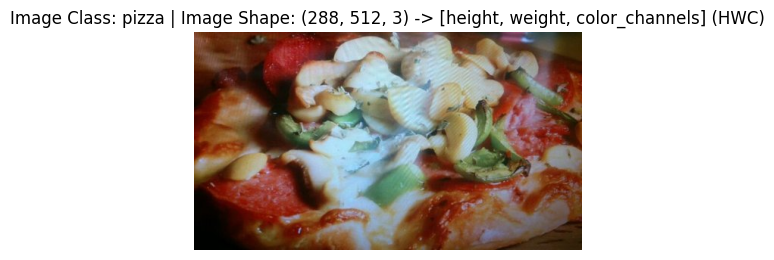

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# turn the image into array
image_as_array = np.asarray(img)

# plot the image
plt.figure(figsize=(5, 3))
plt.imshow(image_as_array)
plt.title(f"Image Class: {image_class} | Image Shape: {image_as_array.shape} -> [height, weight, color_channels] (HWC)")
plt.axis(False)


In [11]:
# print(image_as_array)
# image_as_array --- Why does this one print out the image itself rather than the array?!?!

### 3. Transforming Data

In [12]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets, transforms

#### 3.1 Transforming data with `torchvision.transforms`

In [13]:
# write a transform for image
data_transform = transforms.Compose([
    # resize to 64*64
    transforms.Resize(size=(64, 64)),  # due to the architecture of TinyVGG and input size required
    # flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),  # not necessarily required
    # turn the image into torch.Tensor
    transforms.ToTensor()
])

In [14]:
# dataclass_transform(image_as_array) -> this won't work since it is a numpy array
# so we will have to pass img
data_transform(img).shape

torch.Size([3, 64, 64])

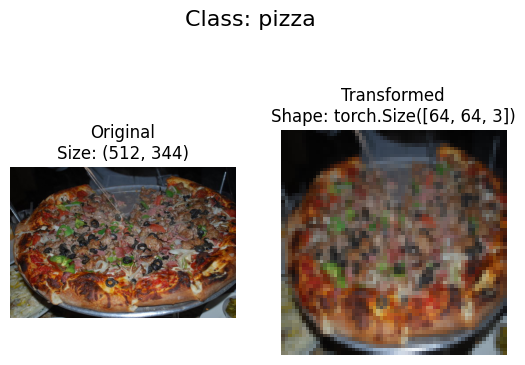

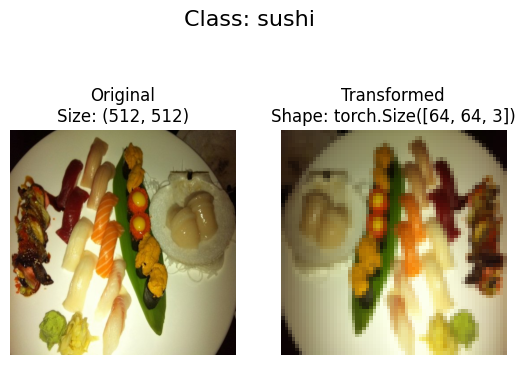

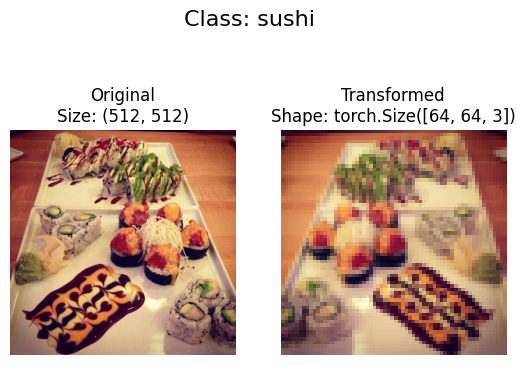

In [15]:
def plot_transformed_images(image_paths: list, transform, n: int, seed=None):
  """
  Selects random images from a path of images and loads/transforms
  them plots the original vs the transformed version.
  """
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      # The line below creates a figure (fig) and a set of two subplots (ax)
      # arranged in a single row (nrows=1) and two columns (ncols=2).
      # The resulting ax array contains references to the two subplots.
      fig, ax = plt.subplots(nrows=1, ncols=2)
      # display the image f on the first plot
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      transformed_image = transform(f).permute(1, 2, 0) # Note: we will need to change shape in matplotlib exploiting premute()
                                       # the shape should be changed due to
                                       # the default order (CHW) while our defined order is (HWC)
                                       # so the change would be like (C, H, W) -> (H, W, C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis("off")   # alternative for ax[1].axis(False)

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)


plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=42)

 #### The transformed adition is 64*64 and therefore there is less information encoded in the image. So, our model would compute faster on images of this size, however, we may lose some performance because not as much information is included as the original image. Last but not least, the size of the image would be another hyperparameter to be tuned.

### 4. Option 1: Loading image data using `ImageFolder`
We can load image classification data using `torchvision.datasets.ImageFolder`

[ChatGPT] ImageFolder is used for loading image datasets from directories with a specific structure, handling file I/O and label assignment automatically.
DataLoader is used for batching, shuffling, and iterating over datasets, making it easier to train models by providing options for batch size, shuffling, and parallel data loading.

In [16]:
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform,  # a transform for the data
                                  target_transform=None)     # a transform for the label/target

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data


(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [17]:
type(train_data), type(test_data)

(torchvision.datasets.folder.ImageFolder,
 torchvision.datasets.folder.ImageFolder)

In [18]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [19]:
# get class names as list
class_names = train_data.classes
class_names


['pizza', 'steak', 'sushi']

In [20]:
# get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [21]:
len(train_data), len(test_data)

(225, 75)

In [22]:
# return labels

# train_data.targets

In [23]:
# .samples: This attribute of the train_data object likely contains a list or another iterable
# containing information about the samples in the dataset. Each element of this list could contain details
# such as the file path of the sample and its corresponding label.
train_data.samples[0], train_data.samples[100], train_data.samples[2], train_data.samples[200]

(('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0),
 ('data/pizza_steak_sushi/train/steak/1976160.jpg', 1),
 ('data/pizza_steak_sushi/train/pizza/1044789.jpg', 0),
 ('data/pizza_steak_sushi/train/sushi/3353428.jpg', 2))

In [24]:
# type(train_data)
train_data[0], train_data[100]   # these return an image tensor and the associated label


((tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
           [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
           [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
           ...,
           [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
           [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
           [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],
  
          [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
           [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
           [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
           ...,
           [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
           [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
           [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],
  
          [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
           [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
           [0.0196, 0.

In [25]:
train_data[0][1], train_data[100][1] # return the labels of 0th and 100th samples respectively

(0, 1)

In [26]:
img, label = train_data[0][0], train_data[0][1]
img, label, class_names[label]

(tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
          [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
          [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
          ...,
          [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
          [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
          [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],
 
         [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
          [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
          [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
          ...,
          [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
          [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
          [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],
 
         [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
          [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
          [0.0196, 0.0157, 0.0157,  ...,

In [27]:
print(f"Image Tensor:\n {img}")
print(f"Image Shape:\n {img.shape}")
print(f"Image Datatype:\n {img.dtype}")
print(f"Image Label:\n {label}")
print(f"Image Datatype:\n {type(label)}")

Image Tensor:
 tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.0

Original shape: torch.Size([3, 64, 64]) -> [color_channel, height, width]
Permuted shape: torch.Size([64, 64, 3]) -> [height, width, color_channel]


Text(0.5, 1.0, 'pizza')

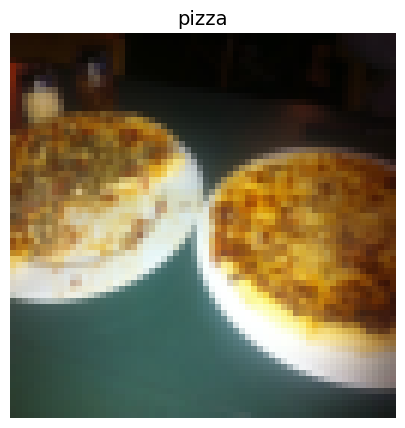

In [28]:
# let's plot through matplotlib

img_permute = img.permute(1, 2, 0)

print(f"Original shape: {img.shape} -> [color_channel, height, width]")
print(f"Permuted shape: {img_permute.shape} -> [height, width, color_channel]")

# Plot the image
plt.figure(figsize=(7, 5))
plt.imshow(img_permute)
plt.axis("off")
plt.title(class_names[label], fontsize=14)

#### 4.1 Our data/images are ready to be batched so that we should turn loaded images into `DataLoader`'s

In [29]:
# Turn train and test datasets into dataloaders

import os
from torch.utils.data import DataLoader

# you can count the number of CPUs your machine/colab instance has
os.cpu_count()

BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=1)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=1)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7ec36005e950>,
 <torch.utils.data.dataloader.DataLoader at 0x7ec3675224d0>)

In [30]:
len(train_dataloader), len(test_dataloader)

(8, 3)

In [31]:
# iter() creates an iterator from the train_dataloader. An iterator allows sequential access to
# the elements of the train_dataloader, which likely contains batches of data for training a machine learning model.
#  It retrieves the next element from the iterator. In the context of a dataloader,
# this typically corresponds to the next batch of data.
img, label = next(iter(train_dataloader))

# Batch size will now be 1, you can change the batch size if you like
print(f"Image shape: {img.shape} -> [batch_size, color_channel, height, width]")

Image shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channel, height, width]


#### What if we had not prepared our datasets through torchvision.datasets.ImageFolder? How can we replicate that functionality?
In fact if we assume that ImageFolder function doesn't exist, we will have to define our own custom dataloader function. Let's see how it works together.

### 5. Option 2: Loading Image Data with a Custom `Dataset`

In [32]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [33]:
# instances of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

#### 5.1 Creating a helper function to get class names

In [34]:
# setup path for target directory
target_directory = train_dir
print(f"Target dir: {target_directory}")

# getclass names from the targte directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [35]:
list(os.scandir(target_directory))

[<DirEntry 'sushi'>, <DirEntry 'steak'>, <DirEntry 'pizza'>]

In [36]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """Find the class folder names in a target directory."""
  # 1. get the class names by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # 2. raise  an error if class names could not be found
  if not classes:
    raise FileNotFoundError(f"Couldn'r ind any classes in {directory} ... Please check file structure.")

  # 3. create dictionary of index labels (computers prefer numbers rather than strings as labels)
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}

  return classes, class_to_idx

In [37]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

#### 5.2 Create custom dataset to replicate `ImageFolder`

In [38]:
# 0. Write a custom dataset class
from torch.utils.data import Dataset

# 1. subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
  # 2. Initialize our custom dataset
  def __init__(self, targ_dir: str, transform=None):
    # 3. create class attributes
    # get all of the image panths
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    # setup transform
    self.transform = transform
    # create classes and class_to_idx attributes
    self.classes, self.class_to_idx = find_classes(targ_dir)

  # 4. Create a function to load images
  def load_image(self, index: int) -> Image.Image:
    "Opens an image via a path and returns it."
    image_path = self.paths[index]
    return Image.open(image_path)

  # 5. Overwrite  __len__()
  def __len__(self) -> int:
    "Returns the total number of samples."
    return len(self.paths)

  # 6. overwrite __getitem__() method to return a particular sample
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    "Return one sample of data, data and label (X, y)"
    img = self.load_image(index)
    class_name = self.paths[index].parent.name # expects path in format: data_folder/class_name/image.jpg
    class_idx = self.class_to_idx[class_name]

    # Transform  if necessary
    if self.transform:
      return self.transform(img), class_idx  # return data, label (X, y)
    else:
      return img, class_idx  # return untransformed image and label

In [39]:
img, label = train_data[0]
img, label

(tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
          [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
          [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
          ...,
          [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
          [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
          [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],
 
         [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
          [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
          [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
          ...,
          [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
          [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
          [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],
 
         [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
          [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
          [0.0196, 0.0157, 0.0157,  ...,

In [40]:
# create a transform
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [41]:
# test our ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)

test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)



In [42]:

train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7ec36005fb80>,
 <__main__.ImageFolderCustom at 0x7ec36005dd50>)

In [43]:
len(train_data), len(train_data_custom)


(225, 225)

In [44]:
len(test_data), len(test_data_custom)

(75, 75)

In [45]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [46]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [47]:
# check for equality between original Image Folder Dataset and ImageFoldeCustomDataset
print(train_data_custom.classes == train_data.classes)
print(test_data_custom.classes == test_data.classes)

True
True


#### 5.3 create a function to display random images

In [48]:
# 1. create a function to take in a dataset
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):

  # 2. adjust display if n is too high
  if n > 10:
    n = 10
    display_shape = False   # if we have 10 images, our display may get out of hand
    print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")

  # 3. set the seed
  if seed:
    random.seed(seed)

  # 4. get random sample indexes
  random_sample_idxs = random.sample(range(len(dataset)), k=n)

  # 5. setup plot
  plt.figure(figsize=(16, 8))

  # 6. loop throughrandom indexes and plot them with matplotlib
  for i, targ_sample in enumerate(random_sample_idxs):
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    # 7. adjust tensor dimensions for plotting
    targ_image_adjust = targ_image.permute(1, 2, 0)  # [color_channels, height, width] -> [height, width, color_channels]

    # plot adjusted samples
    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis(False)
    if classes:
      title = f"Class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nshape: {targ_image_adjust.shape}"
    plt.title(title)

In [49]:
random.sample(range(len(train_data_custom)), k=10)

[62, 57, 35, 188, 26, 173, 189, 139, 22, 151]

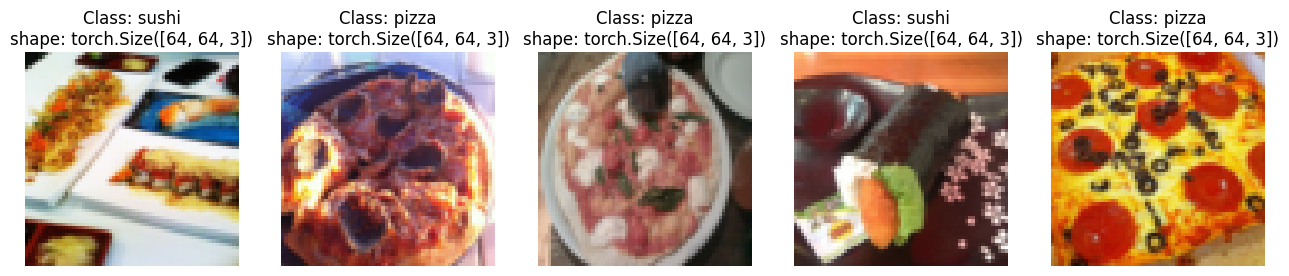

In [50]:
display_random_images(train_data,
                      n=5,
                      classes=class_names,
                      seed=42)

For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.


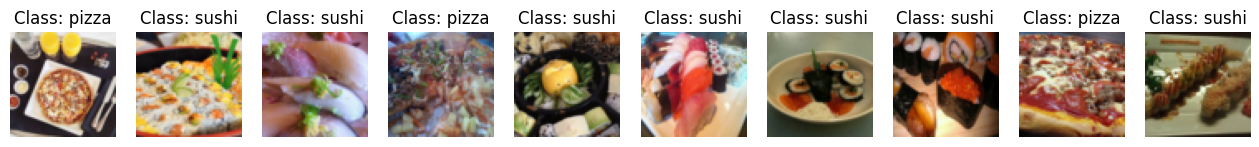

In [51]:
# display random images from ImageFolderCustom Dataset
display_random_images(train_data_custom,
                      n=20,
                      classes=class_names,
                      seed=42)

#### 5.4 Turn custom loaded images into `DataLoader`'s

In [52]:
from torch.utils.data import DataLoader

BATCH_SIZE= 32
NUM_WORKERS = os.cpu_count()
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size = BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS)

In [53]:
train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7ec3600aeaa0>,
 <torch.utils.data.dataloader.DataLoader at 0x7ec35f97e590>)

In [54]:
img_custom, label_custom = next(iter(train_dataloader_custom))

img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

### 6. Other Forms of Data Augmentation

In [55]:
# Let's look at TrivialAugment

from torchvision import transforms

train_transform = transforms.Compose([transforms.Resize(size=(224, 224)),
                                      transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                      transforms.ToTensor()])
test_transform = transforms.Compose([transforms.Resize(size=(224, 224)),
                                     transforms.ToTensor()])

In [56]:
image_path

PosixPath('data/pizza_steak_sushi')

In [57]:
# get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
# image_path_list

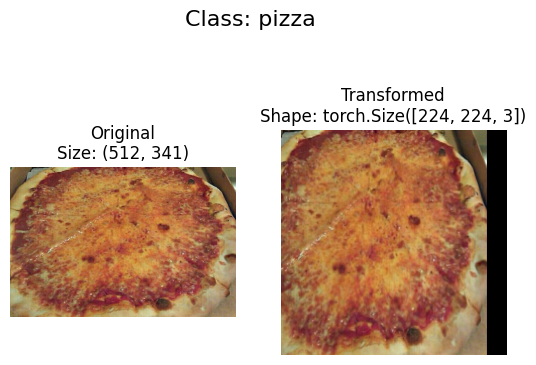

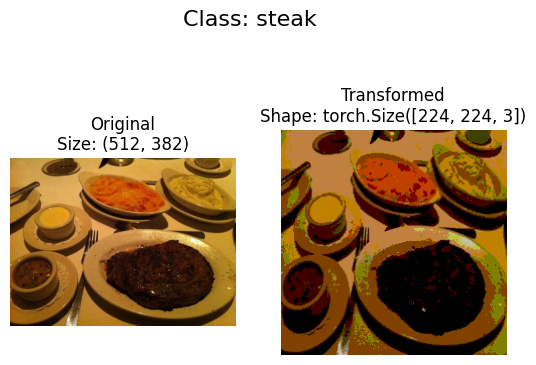

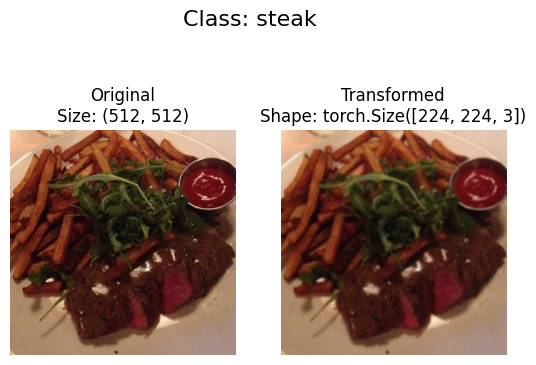

In [58]:
plot_transformed_images(
    image_paths=image_path_list,
    transform=train_transform,
    n=3,
    seed=None
)

### 7. Model 0: TinyVGG without data augmentation

#### 7.1 Creating transforms and loading data for model 0

In [59]:
# create simple transform (without data augmentation)
simple_transform = transforms.Compose([transforms.Resize(size=(64, 64)),
                                       transforms.ToTensor()])

In [60]:
# 1. load and transform  data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=simple_transform)

# 2. turn the dataset into DataLoaders
import os
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)
test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)

#### 7.2 Create TinyVGG model from scratch

In [61]:
import torch.nn as nn

class TinyVGG(nn.Module):
  """

  """
  def __init__(self, input_shape: int, output_shape: int, hidden_units: int) -> None:
    super().__init__()

    self.conv_layer_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) # default value is the same as kernel_size
    )

    self.conv_layer_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) # default value is the same as kernel_size
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13,
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_layer_1(x)
    # print(x.shape)    # these prints can also help you track where a potential error has been raised
    x = self.conv_layer_2(x)
    # print(x.shape)
    x = self.classifier(x)
    # print(x.shape)
    return x
    # OR return self.classifier(self.conv_layer_2(self.conv_layer_1(x))) -> benefits from operator fusion and speeds up GPU performance
    # but in the previous format the processor accesses memory after each computation of x
    # which is not an optimized approach to follow as a professional

In [62]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3,
                  output_shape=len(class_names),
                  hidden_units=10).to(device)

model_0

TinyVGG(
  (conv_layer_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

#### 7.3 Try a forward pass on single image(to test the model)

In [63]:
# get a single image batch
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [64]:
model_0(image_batch).to(device)

tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4668e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9131e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6415e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0239e-02, -4.7979e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1816e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7225e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3995e-03,  9.4990e-03],
        [ 2.2101e-02, -4.1469e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.1665e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 2.0768e-02

In [65]:
# try installing torchinfo, import if it is already available
try:
  import torchinfo
except:
  !pip install torchinfo
  from torchinfo import summary

summary(model_0, input_size=(BATCH_SIZE, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 30, 30]          --
│    └─Conv2d: 2-1                       [32, 10, 62, 62]          280
│    └─ReLU: 2-2                         [32, 10, 62, 62]          --
│    └─Conv2d: 2-3                       [32, 10, 60, 60]          910
│    └─ReLU: 2-4                         [32, 10, 60, 60]          --
│    └─MaxPool2d: 2-5                    [32, 10, 30, 30]          --
├─Sequential: 1-2                        [32, 10, 13, 13]          --
│    └─Conv2d: 2-6                       [32, 10, 28, 28]          910
│    └─ReLU: 2-7                         [32, 10, 28, 28]          --
│    └─Conv2d: 2-8                       [32, 10, 26, 26]          910
│    └─ReLU: 2-9                         [32, 10, 26, 26]          --
│    └─MaxPool2d: 2-10                   [32, 10, 13, 13]          --
├─Sequentia

  #### 7.5 Create train and test loop functions `train_step()` and `test_step()`

In [66]:
# create train step
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):
  model.train()

  train_loss, train_acc = 0, 0

  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    y_logits = model(X)   # output model logits
    loss = loss_fn(y_logits, y)
    train_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # calculate accuracy metrics
    y_pred = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)
    train_acc += (y_pred==y).sum().item() / len(y_pred)

  # adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)

  return train_loss, train_acc

In [67]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):

  model.eval()

  test_loss, test_acc = 0, 0

  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)

      test_logits = model(X)
      loss = loss_fn(test_logits, y)
      test_loss += loss.item()

      test_labels = test_logits.argmax(dim=1) # it is not necessary to pass through softmax
      test_acc += ((test_labels == y).sum().item() / len(test_labels))

  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)

  return test_loss, test_acc

#### 7.6 Combine `train_step()` and `test_step()` like 2 in 1.

In [68]:
from tqdm.auto import tqdm

#1. create a trian function
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn:torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device=device):

  #2. create ampty results deictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                      dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)

    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)

    # 4. Print out what's happening
    print(
        f"Epoch: {epoch+1} | "
        f"train_loss: {train_loss:.4f} | "
        f"train_acc: {train_acc:.4f} | "
        f"test_loss: {test_loss:.4f} | "
        f"test_acc: {test_acc:.4f}"
    )

    # 5. update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  return results

#### 7.7 Train and evaluate model 0

In [69]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

EPOCHS = 5

model_0 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

from timeit import default_timer as timer
start_time = timer()

model_0_results = train(model_0,
                        train_dataloader_simple,
                        test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=EPOCHS)

end_time = timer()

print(f"Total training time: {end_time-start_time: .3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1063 | train_acc: 0.3047 | test_loss: 1.0983 | test_acc: 0.3011
Epoch: 2 | train_loss: 1.0998 | train_acc: 0.3281 | test_loss: 1.0697 | test_acc: 0.5417
Epoch: 3 | train_loss: 1.0869 | train_acc: 0.4883 | test_loss: 1.0808 | test_acc: 0.4924
Epoch: 4 | train_loss: 1.0842 | train_acc: 0.3984 | test_loss: 1.0608 | test_acc: 0.5833
Epoch: 5 | train_loss: 1.0662 | train_acc: 0.4141 | test_loss: 1.0654 | test_acc: 0.5644
Total training time:  14.996 seconds


In [70]:
model_0_results

{'train_loss': [1.106319084763527,
  1.0998057276010513,
  1.0868544578552246,
  1.0842333137989044,
  1.0662163347005844],
 'train_acc': [0.3046875, 0.328125, 0.48828125, 0.3984375, 0.4140625],
 'test_loss': [1.0983205238978069,
  1.069690187772115,
  1.0807572205861409,
  1.0608317852020264,
  1.065395991007487],
 'test_acc': [0.30113636363636365,
  0.5416666666666666,
  0.49242424242424243,
  0.5833333333333334,
  0.5643939393939394]}

#### 7.8 plot the loss curves of model 0

In [71]:
def plot_loss_curves(results: Dict[str, List[float]]):
  """Plots the training curves of a results dictionary"""
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  epochs = range(len(results["train_loss"]))

  # set up a plot
  plt.figure(figsize=[15, 7])

  # # plot the loss
  # plt.subplot(1, 2, 1)
  # plt.plot(epochs, loss, label="Train Loss")
  # plt.plot(epochs, test_loss, label="Test Loss")
  # plt.title("Loss")
  # plt.xlabel("Epochs")
  # plt.legend()

  # # plot the accuracy
  # plt.subplot(1, 2, 2)
  # plt.plot(epochs, accuracy, label="Train Accuracy")
  # plt.plot(epochs, test_accuracy, label="Test Accuracy")
  # plt.title("Accuracy")
  # plt.xlabel("Epochs")
  # plt.legend()

  # Plot loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label='train_loss')
  plt.plot(epochs, test_loss, label='test_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label='train_accuracy')
  plt.plot(epochs, test_accuracy, label='test_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

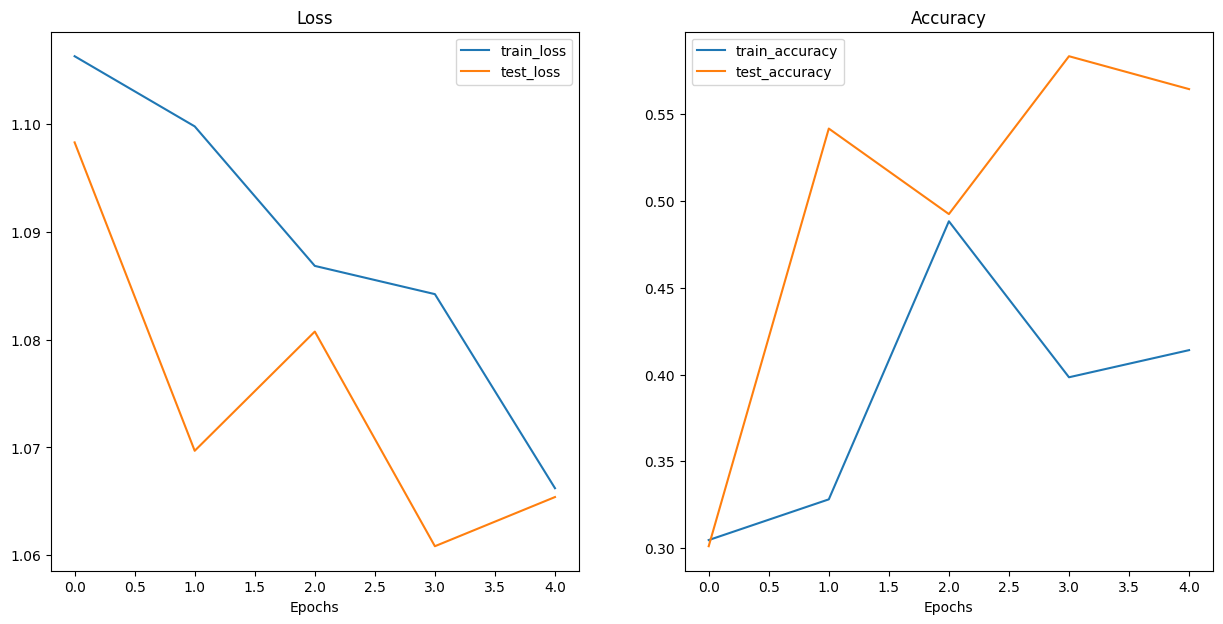

In [72]:
plot_loss_curves(model_0_results)

### 8. What should an ideal Loss Curve look like?
https://www.learnpytorch.io/04_pytorch_custom_datasets/#8-what-should-an-ideal-loss-curve-look-like

### 9. Model 1: TinyVGG with Data Augmentation

#### 9.1 Create transform with data augmentation

In [73]:
# Turn image folders into Datasets
from torchvision import transforms
train_transform_trivial = transforms.Compose([transforms.Resize(size=(64, 64)),
                                              transforms.TrivialAugmentWide(num_magnitude_bins=31),
                                              transforms.ToTensor()])

test_transform_simple = transforms.Compose([transforms.Resize(size=(64, 64)),
                                             transforms.ToTensor()])

In [74]:
# Turn image folders into Datasets
from torchvision import datasets

train_data_augmented = datasets.ImageFolder(root=train_dir,
                                            transform=train_transform_trivial)

test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=test_transform_simple)

In [75]:
# Turn our datasets into DataLoaders
import os
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

#### 9.3 Construct and train model 1

In [76]:
torch.manual_seed(42)

model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data_augmented.classes)).to(device)

print(summary(model_1))
print("                 ")
print("-----------------")
print("-----------------")
print("                 ")
print(model_1)

Layer (type:depth-idx)                   Param #
TinyVGG                                  --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       280
│    └─ReLU: 2-2                         --
│    └─Conv2d: 2-3                       910
│    └─ReLU: 2-4                         --
│    └─MaxPool2d: 2-5                    --
├─Sequential: 1-2                        --
│    └─Conv2d: 2-6                       910
│    └─ReLU: 2-7                         --
│    └─Conv2d: 2-8                       910
│    └─ReLU: 2-9                         --
│    └─MaxPool2d: 2-10                   --
├─Sequential: 1-3                        --
│    └─Flatten: 2-11                     --
│    └─Linear: 2-12                      5,073
Total params: 8,083
Trainable params: 8,083
Non-trainable params: 0
                 
-----------------
-----------------
                 
TinyVGG(
  (conv_layer_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
   

In [77]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 5

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_1
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1049 | train_acc: 0.2500 | test_loss: 1.1019 | test_acc: 0.2604
Epoch: 2 | train_loss: 1.0807 | train_acc: 0.4258 | test_loss: 1.1261 | test_acc: 0.2604
Epoch: 3 | train_loss: 1.0712 | train_acc: 0.4258 | test_loss: 1.1593 | test_acc: 0.2604
Epoch: 4 | train_loss: 1.1253 | train_acc: 0.3047 | test_loss: 1.1581 | test_acc: 0.2604
Epoch: 5 | train_loss: 1.0865 | train_acc: 0.4258 | test_loss: 1.1554 | test_acc: 0.3333
Total training time: 16.744 seconds


In [78]:
 model_1_results

{'train_loss': [1.1049142181873322,
  1.0806865319609642,
  1.0711720064282417,
  1.125308871269226,
  1.0865341275930405],
 'train_acc': [0.25, 0.42578125, 0.42578125, 0.3046875, 0.42578125],
 'test_loss': [1.1019279956817627,
  1.1260557969411213,
  1.159274419148763,
  1.1580669283866882,
  1.1554276545842488],
 'test_acc': [0.2604166666666667,
  0.2604166666666667,
  0.2604166666666667,
  0.2604166666666667,
  0.3333333333333333]}

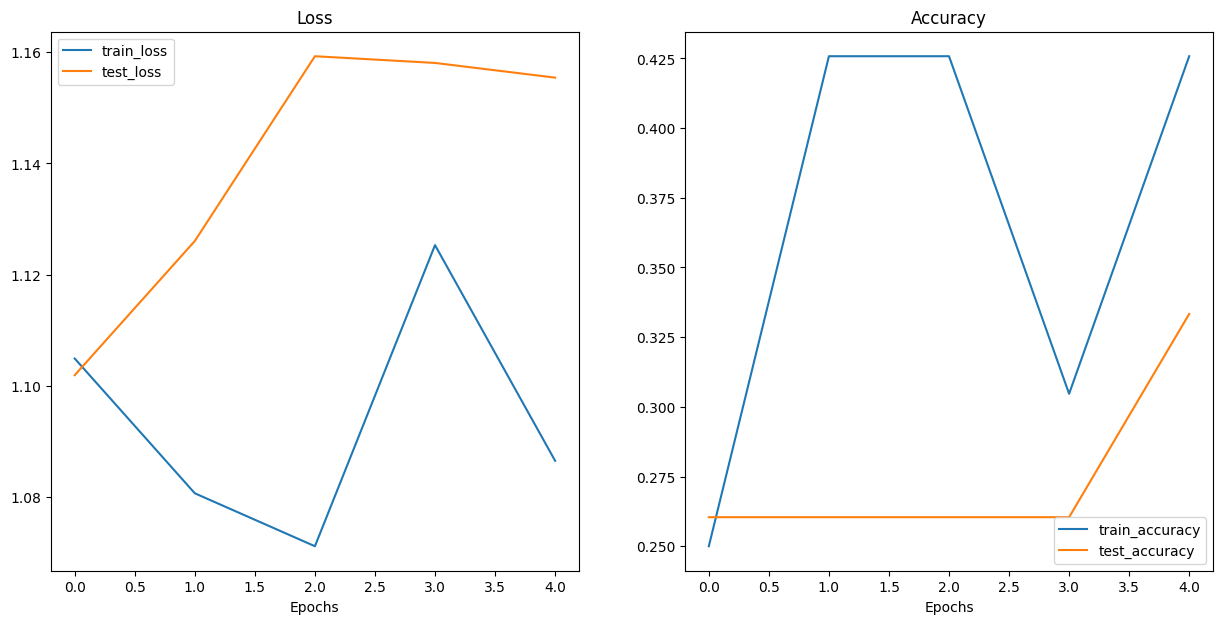

In [79]:
plot_loss_curves(model_1_results)

### Approaches to evaluate our modelling:
1. Hard coding
2. PyTorch + Tensorboard
3. Weights & Biases
4. MLFlow
#### But we stick to hard coding for now!

In [80]:
 import pandas as pd

 model_0_df = pd.DataFrame(model_0_results)
 model_1_df = pd.DataFrame(model_1_results)
 model_0_df

,train_loss,train_acc,test_loss,test_acc
0,1.106319,0.304688,1.098321,0.301136
1,1.099806,0.328125,1.069690,0.541667
2,1.086854,0.488281,1.080757,0.492424
3,1.084233,0.398438,1.060832,0.583333
4,1.066216,0.414062,1.065396,0.564394


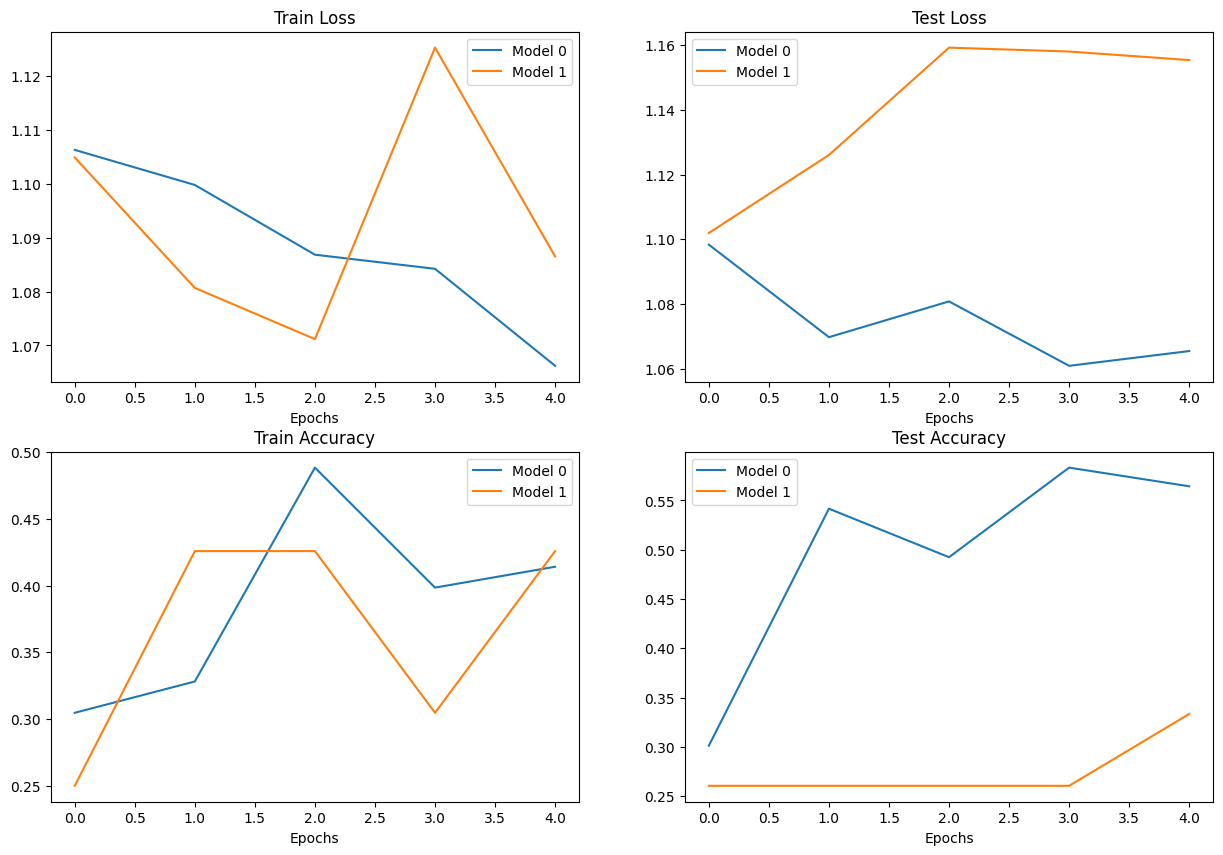

In [81]:
# set up a plot
plt.figure(figsize=(15, 10))

# get the numbr of epochs
epochs = range(len(model_0_df))
# print(epochs)

#plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

#plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

#plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

#plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend()



###11. Making prediction on some custom images

In [82]:
# First let us download some custom image

import requests

# set up custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    # be careful to use the raw file link when downloading from GitHub
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/blob/main/images/04-pizza-dad.jpeg?raw=true")
    print(f"Downloading form {custom_image_path}...")
    f.write(request.content)
    print(f"Download complete!")
else:
  print(f"{custom_image_path} already exists, skipping download...")

Download complete!


#### 11.1 Loading in a custom image by PyTorch

In [83]:
import torchvision

custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))
custom_image_uint8

tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)

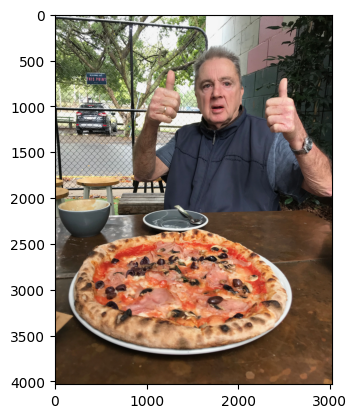

In [84]:
plt.imshow(custom_image_uint8.permute(1, 2, 0))

In [85]:
model_1.eval()
with torch.inference_mode():
  model_1(custom_image_uint8.to(device))

RuntimeError: Input type (unsigned char) and bias type (float) should be the same

In [86]:
# in order to fix the error above
# load in the custom image and convert to torch.float32

custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) / 255
custom_image
# custom_image.shape

tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..., 0.0549, 0.0510, 0.

At first, the values of the tensor were not between 0-1, but 0-255 therefore, we can divide them all by 255 since the largest value is 255.

In [87]:
# This will error: image not on the right device
model_1.eval()
with torch.inference_mode():
  model_1(custom_image.to(device))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x756765 and 1690x3)

Now we notice that the matrix sizes do not match, so we'd better apply some kind of transformation.

In [88]:
from torchvision import transforms

transformer = transforms.Compose([transforms.Resize(size=(64, 64))])

custom_image_transformed = transformer(custom_image)

print(f"Original shape: {custom_image.shape}")
print(f"Transformed shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 4032, 3024])
Transformed shape: torch.Size([3, 64, 64])


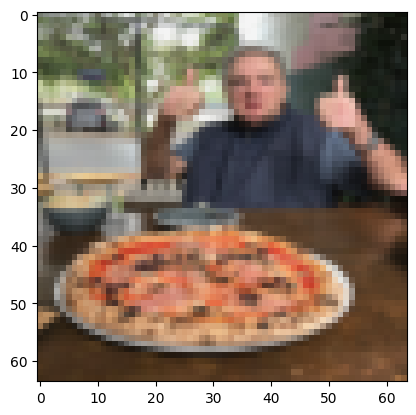

In [89]:
plt.imshow(custom_image_transformed.permute(1,2,0))

In [90]:
# This will error: image not on the right device
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x169 and 1690x3)

In [91]:
# This will error: \no batch size
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed.to(device))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x169 and 1690x3)

In [92]:
# add batch size / extend dimension
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed.unsqueeze(0).to(device))
custom_image_pred

tensor([[ 0.0780,  0.0379, -0.2067]])

#### Steps to make a prediction on a custom image:
* Load the image and turn it into a tensor
* Make sure the image was the same datatype as the model (tensor.float32)
* Make sure the image is the same shape as the model was trained on (3, 64, 64) with a batch size ... (1, 3, 64, 64)
* Make sure the image was on the same device as our model.

In [96]:
# convert logits --> prediction probabilities
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
custom_image_pred_probs

tensor([[0.3686, 0.3541, 0.2773]])

In [98]:
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1).cpu()
custom_image_pred_label

tensor([0])

In [99]:
class_names[custom_image_pred_label]

'pizza'

#### 11.3 Putting custom image prediction together: building a function

In [100]:
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform=None,
                        device=device):
  """Predict given an image and plot the image and prediction"""

  target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)
  # get image pixel values between [0, 1]
  target_image = target_image / 255

  if transform:
    target_image = transform(target_image)

  # make sure the model is on target device
  model.to(device)

  model.eval()
  with torch.inference_mode():
      # Add an extra dimension to the image
      target_image = target_image.unsqueeze(dim=0)

      # Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(target_image.to(device))

  # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
  target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

  # 7. Convert prediction probabilities -> prediction labels
  target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

  # 8. Plot the image alongside the prediction and prediction probability
  plt.imshow(target_image.squeeze().permute(1, 2, 0)) # make sure it's the right size for matplotlib
  if class_names:
      title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
  else:
      title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
  plt.title(title)
  plt.axis(False);

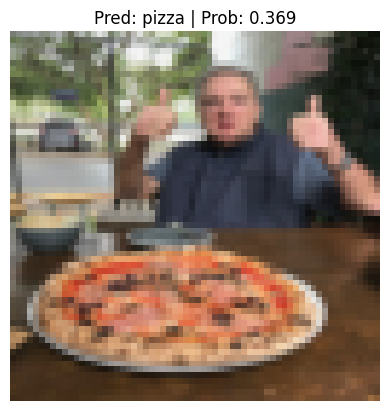

In [102]:
pred_and_plot_image(model=model_1,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=transformer,
                    device=device)